# Introduction


Initial stage of preparation any neural network, as paradoxical as it may sound, it's not about writing neural net code at all - it's about inspecting data you have for training. This stage can take units of hours and key activity here - looking for duplication, data imbalances, checking for noisy labels - if you have them. All this tasks might be done much more faster, if you have right tool. The purpose of this notebook will be a simple clustering of input images. If your goal is to remove duplicates, then a more computationally beneficial way - fit autoencoder with simple activation function (e.g. ReLU). We will focus on displaying similar images, with some caveat: we do not know the similarity criterion. It is also important to remember that there is no uniquely best criterion for the quality of clustering - the combination of 2 previous facts indicates some uncertainty as a result. But even so, this approach will allow us to detect some patterns, which will speed up data inspection even on a small dataset.

Our plan consists of only 3 points:
1. Get a vector characterizing some high-level features of the current image for each image (such vectors are called embeddings)
2. Using the obtained descriptions, perform regular clustering
3. Visualize / save the results in the appropriate directory

In [1]:
import torch
import torchvision
from torchvision import transforms, models
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams['figure.figsize'] = (13.0, 5.0)

# Extract features from images

The first step in clustering images is preparing a high-level description. We use neural networks to create such a description. Despite the fact that we essentially do not know what is happening inside, we do know something: in order to make meaningful decisions, such as classifying the patterns represented by an image, a neural network needs to learn how to extract factors that are of great importance in representing of a particular pattern.

And that's exactly what we need.

For the current task will be used __[ResNet152](https://arxiv.org/abs/1512.03385)__, fortunately, it's implementation is contained in PyTorch. The last layer is here: Fully connected - which converts 2048 features into 1000 numbers: each number represents the probability that a representative of the corresponding class is in the image - also known as a linear classifier. For the current task, only those features that form the network before entering the linear classifier are important - therefore, we need to delete the last layer. We will replace it with a layer that returns the received data unchanged.

In [2]:
model = models.resnet152(pretrained=True)

class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
model.fc = Identity()

# Disable grad for entire ResNet - we don't want to adjust parameters
for param in model.parameters():
    param.requires_grad = False
# ResNet consist a lot of BatchNorm2D layers. Method 'eval()'
# will allow us not to change the accumulated statistics
model.eval();

In [3]:
# data preparation
transforms_block = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # normalization used during ResNet training
    transforms.Normalize([0.485, 0.456, 0.406], #mean
                         [0.229, 0.224, 0.225]) #std
])

dataset = torchvision.datasets.ImageFolder('data', transforms_block)

In [4]:
# embeddings preparation
batch_size=20

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
model.to(device)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
embeddings = []

with torch.no_grad():
    for inputs, _ in tqdm(dataloader, total=len(dataset)/batch_size):
        inputs.to(device)
        descriptions = model(inputs)
        embeddings.append(descriptions.detach().cpu().numpy())

embeddings = np.concatenate(embeddings, 0)

100%|██████████████████████████████████████████| 5/5.0 [02:41<00:00, 32.39s/it]


In [5]:
del model, dataset, dataloader

In [6]:
# [Number_of_images, feature_map]
embeddings.shape

(100, 2048)

In [7]:
torch.save({'embeddings': embeddings}, 'img_embedding.pt')
# embeddings = torch.load('img_embedding.pt')['embeddings']

# Clustering
We will use the extracted features as a unique representation of each image. The next step is to look at the descriptions of each image, looking for something in common, and combine some of them into one group. For this we will try out a method called K-means (Centroid-based clustering)

## K-means
k-means clustering - clustering method based on prototypes, where the prototype is its cluster centroid: the center of mass of an object, of which it is composed.The optimization goal is to find such clusters where the total square deviation of its members from the cluster centroid is minimal:
$$x_i\in C_k \Leftrightarrow \mu_k = arg\ \underset{\mu_j}{min}||x_i - \mu_i||^2$$.

Accordingly, the search for clusters will be reduced to minimizing the total squared deviation of cluster points from the centroids of these clusters:
$$L(C)=\sum\limits_{j=1}^k\sum\limits_{x_i \in C_j}{||x_i-\mu_j||^2}$$.

We conclude that the centroid of a cluster is its center of mass by solving the following equation:

$$\frac{\partial L(C)}{\partial \mu_k}=0$$

$$\mu_k=\frac{\sum\limits_{x_i \in C_k}x_i}{|C_k|}$$

Nevertheless, in order to find the global minimum, it is necessary to enumerate all possible combinations, provided that the inclusion of an element in one cluster implies its absence in another. Even for a set of 100 elements and 8 clusters, the result number is very large, which makes this task __[computationally difficult](https://en.wikipedia.org/wiki/NP-hardness)__.

Despite the difficulties in finding the global optimum, there are a number of heuristics that allow you to quickly find the local optimum. We will consider the algorithm of one of them below.

1.    **Initializing centroids:** $\mu_1, \mu_2, ..., \mu_k$
2.    **Updating clusters:** objects are assigned to the nearest centroid
3.    **Updating centroids:** recalculation of the centroid position as the center of mass of objects that lie in the corresponding cluster

Steps 2-3 are repeated until the new centroid assignments match the old ones (or until the maximum number of steps is reached). Demonstration with random initialization of centroids below

![title](img/kmeans.png)
It is not difficult to guess that the result may differ, depending on the number of clusters and on the initial initialization of centroids. To select the number of clusters, we'll use Elbow Method, and for initial initialization - "Kmeans++". You can read about both approaches __[here](https://en.wikipedia.org/wiki/Elbow_method_(clustering))__ and __[here](https://en.wikipedia.org/wiki/K-means%2B%2B)__.

In [8]:
from sklearn.cluster import KMeans

### Find out better number of clusters (Elbow Method)

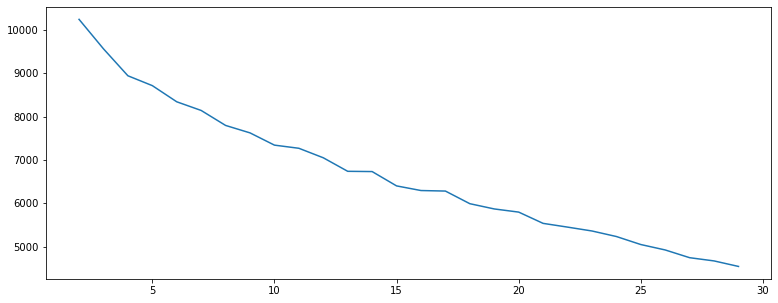

In [9]:
distance_list = []
for k in range(2,30):
    kmeansModel=KMeans(n_clusters=k, init='k-means++', random_state=0)
    kmeansModel.fit(embeddings)
    #Sum of squared distances of samples to their closest cluster center
    distance_list.append(kmeansModel.inertia_)
plt.plot(range(2,30), distance_list);

This method is usually more expressive. The exception in this case suggests that embeddings are distributed more or less evenly in space. However, the existence of irregularities in the graph indicates imperfect uniformity. Several suitable points are noticeable on the chart - we'll use the number of clusters equal to 4.

In [10]:
kmeansModel=KMeans(n_clusters=4, random_state=0)
kmeansModel.fit(embeddings)
kmeans_labels = kmeansModel.labels_

At this step, labels were obtained for each of the images. Our next step: visualization of the obtained results and / or their saving in the appropriate directories

In [15]:
from PIL import Image
import os
import shutil

# Visualization results

In [12]:
def print_clusters(root, content, clusters):
    '''
    :root: directory storing clustered files
    :content: filenames in the given directory
    :clusters: file indices belonging to each cluster
    The function displays the contents of each cluster
    '''
    columns = 8
    
    for c in range(len(clusters)):
        print(f'Cluster {c}:')
        n=len(clusters[c])
        fig=plt.figure(figsize=(60, n*columns))
        for i in range(n):
            img = Image.open(root+'/'+content[clusters[c][i]])
            fig.add_subplot(n, columns, i+1)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
        plt.show()

In [13]:
# form list of indices for every cluster
def form_indices(labels):
    clusters_types=list(set(labels))
    unique_clusters=len(clusters_types)
    #List with indices for every label type
    formed_indices=[[] for x in range(unique_clusters)]
    
    for l in range(len(labels)):
        for t in range(unique_clusters):
            if labels[l]==clusters_types[t]:
                formed_indices[t].append(l)
                break #interrupt finding if type was discovered
                
    return formed_indices

In [16]:
clusters_kmean = form_indices(kmeans_labels)
# The main directory contains only 1 folder!
main_catalog= 'data/'+ os.listdir('data')[0]
files_list=os.listdir(main_catalog)

Cluster 0:


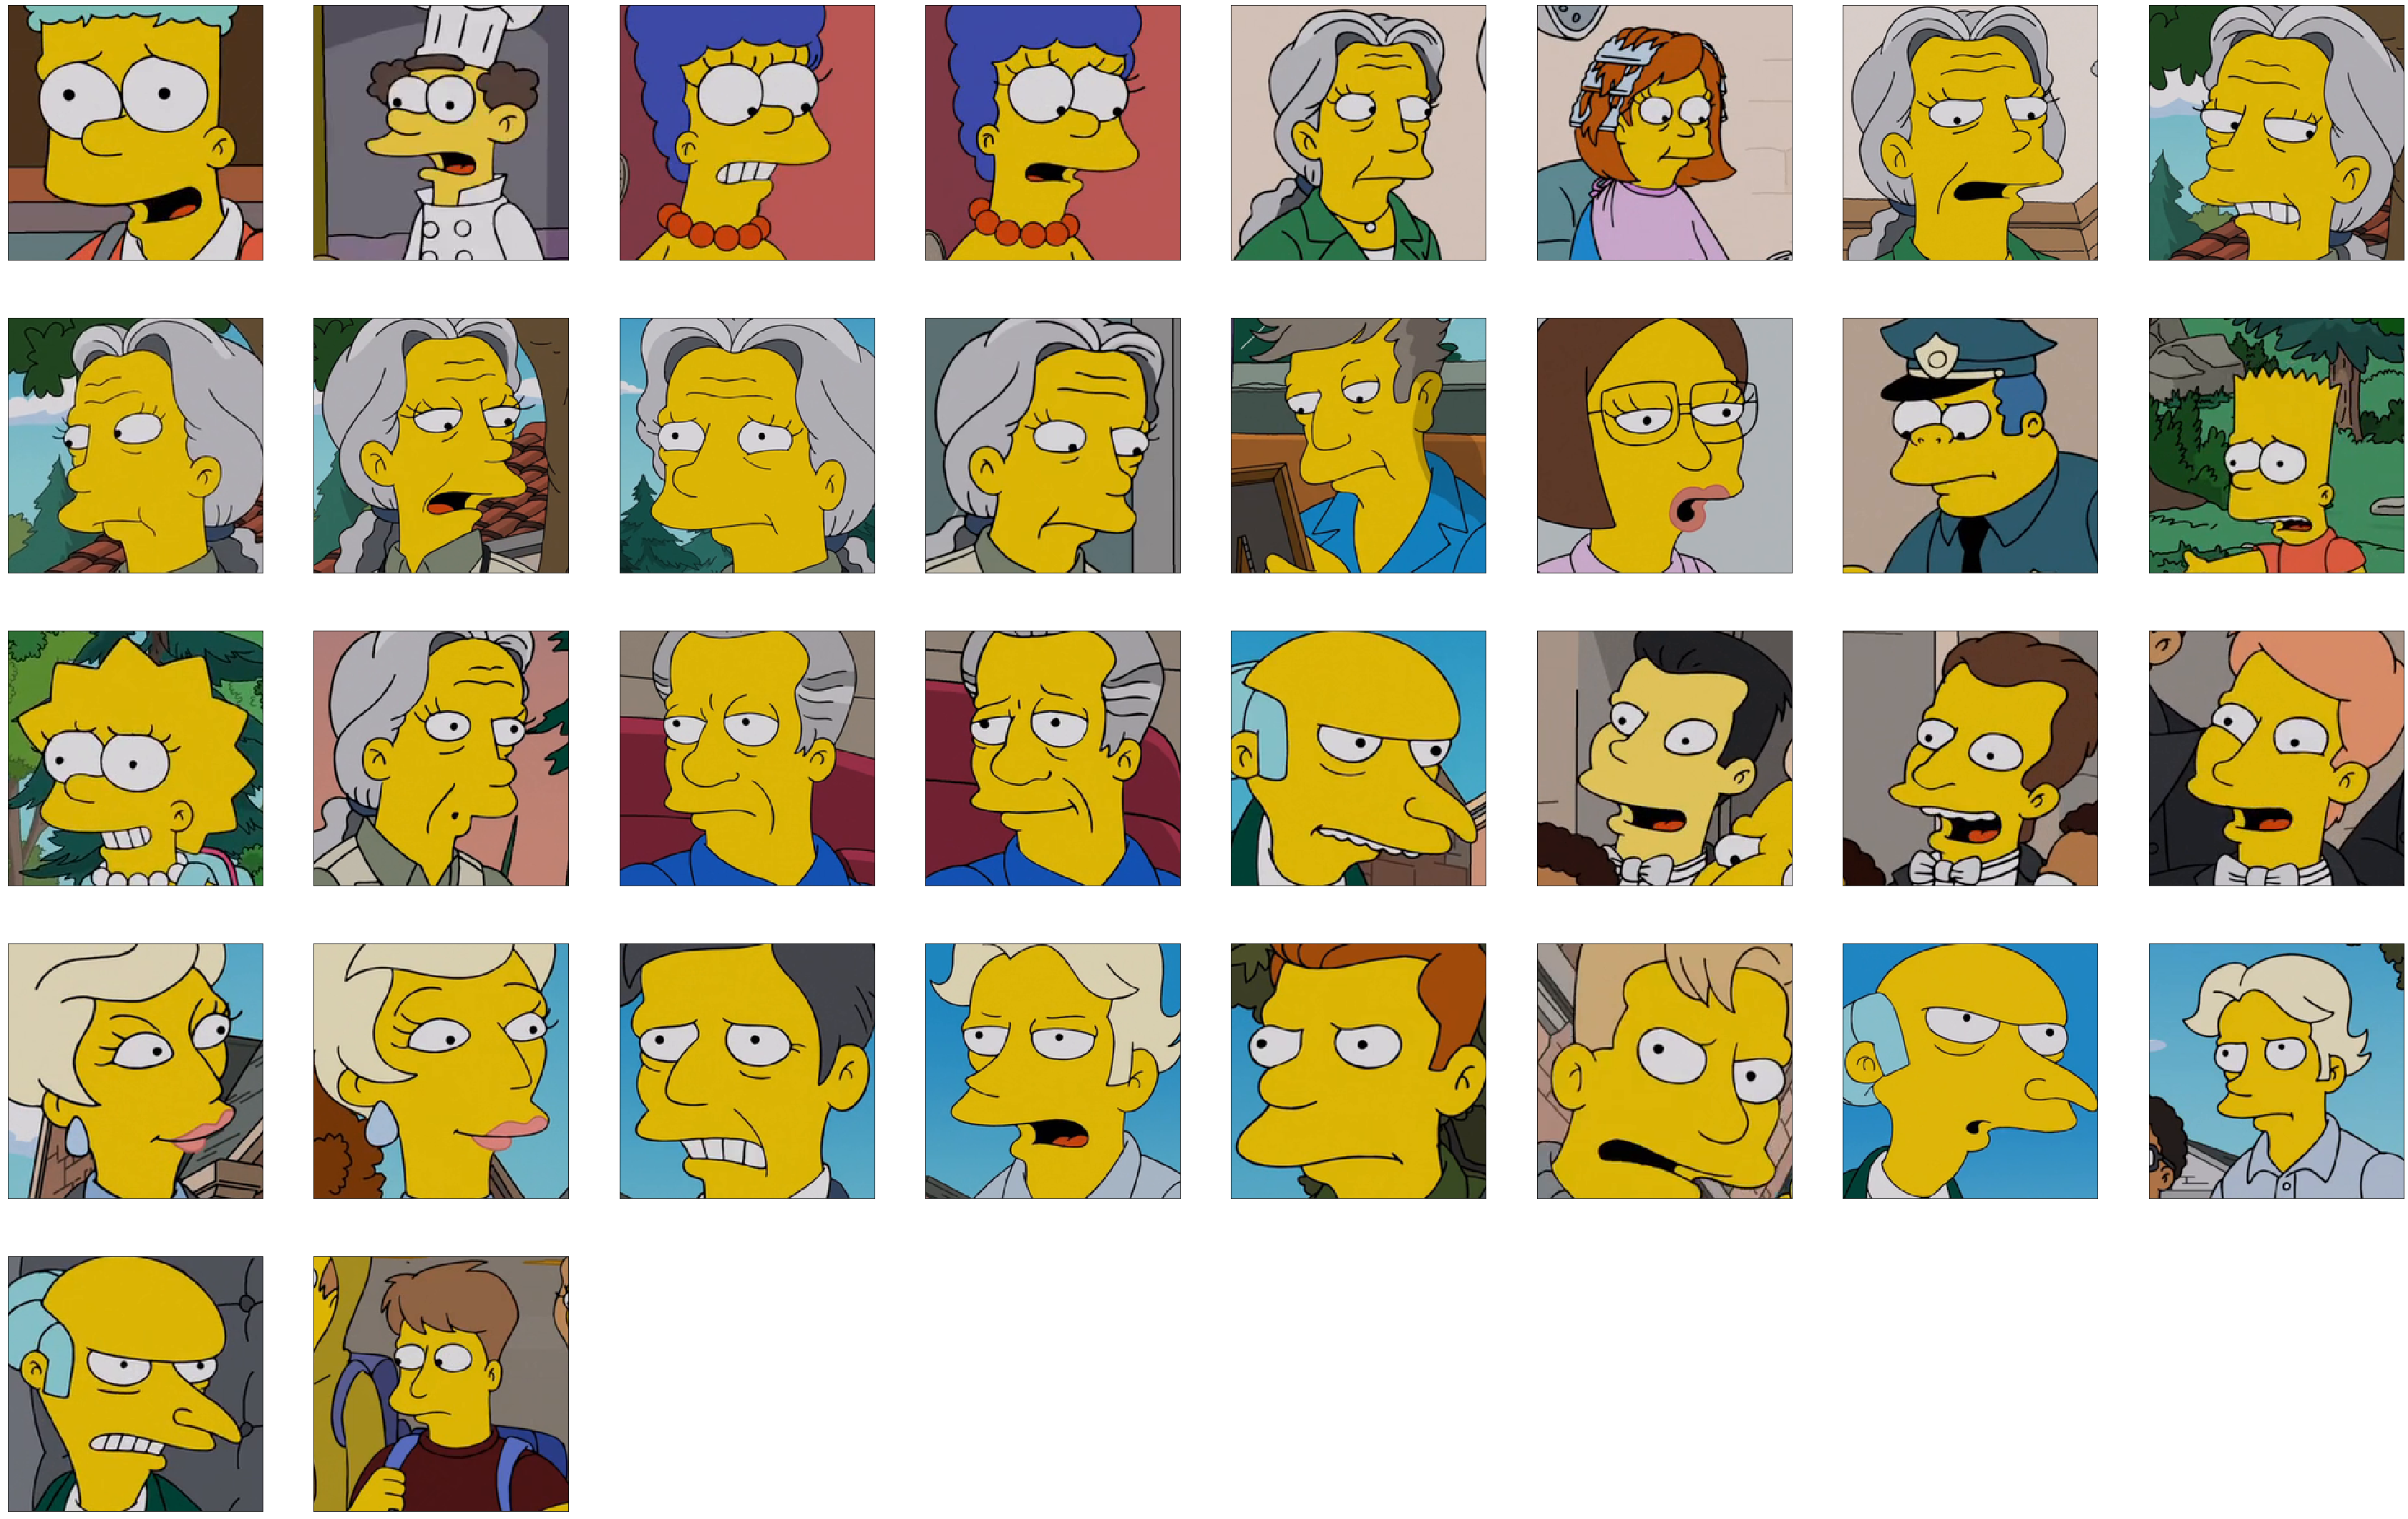

Cluster 1:


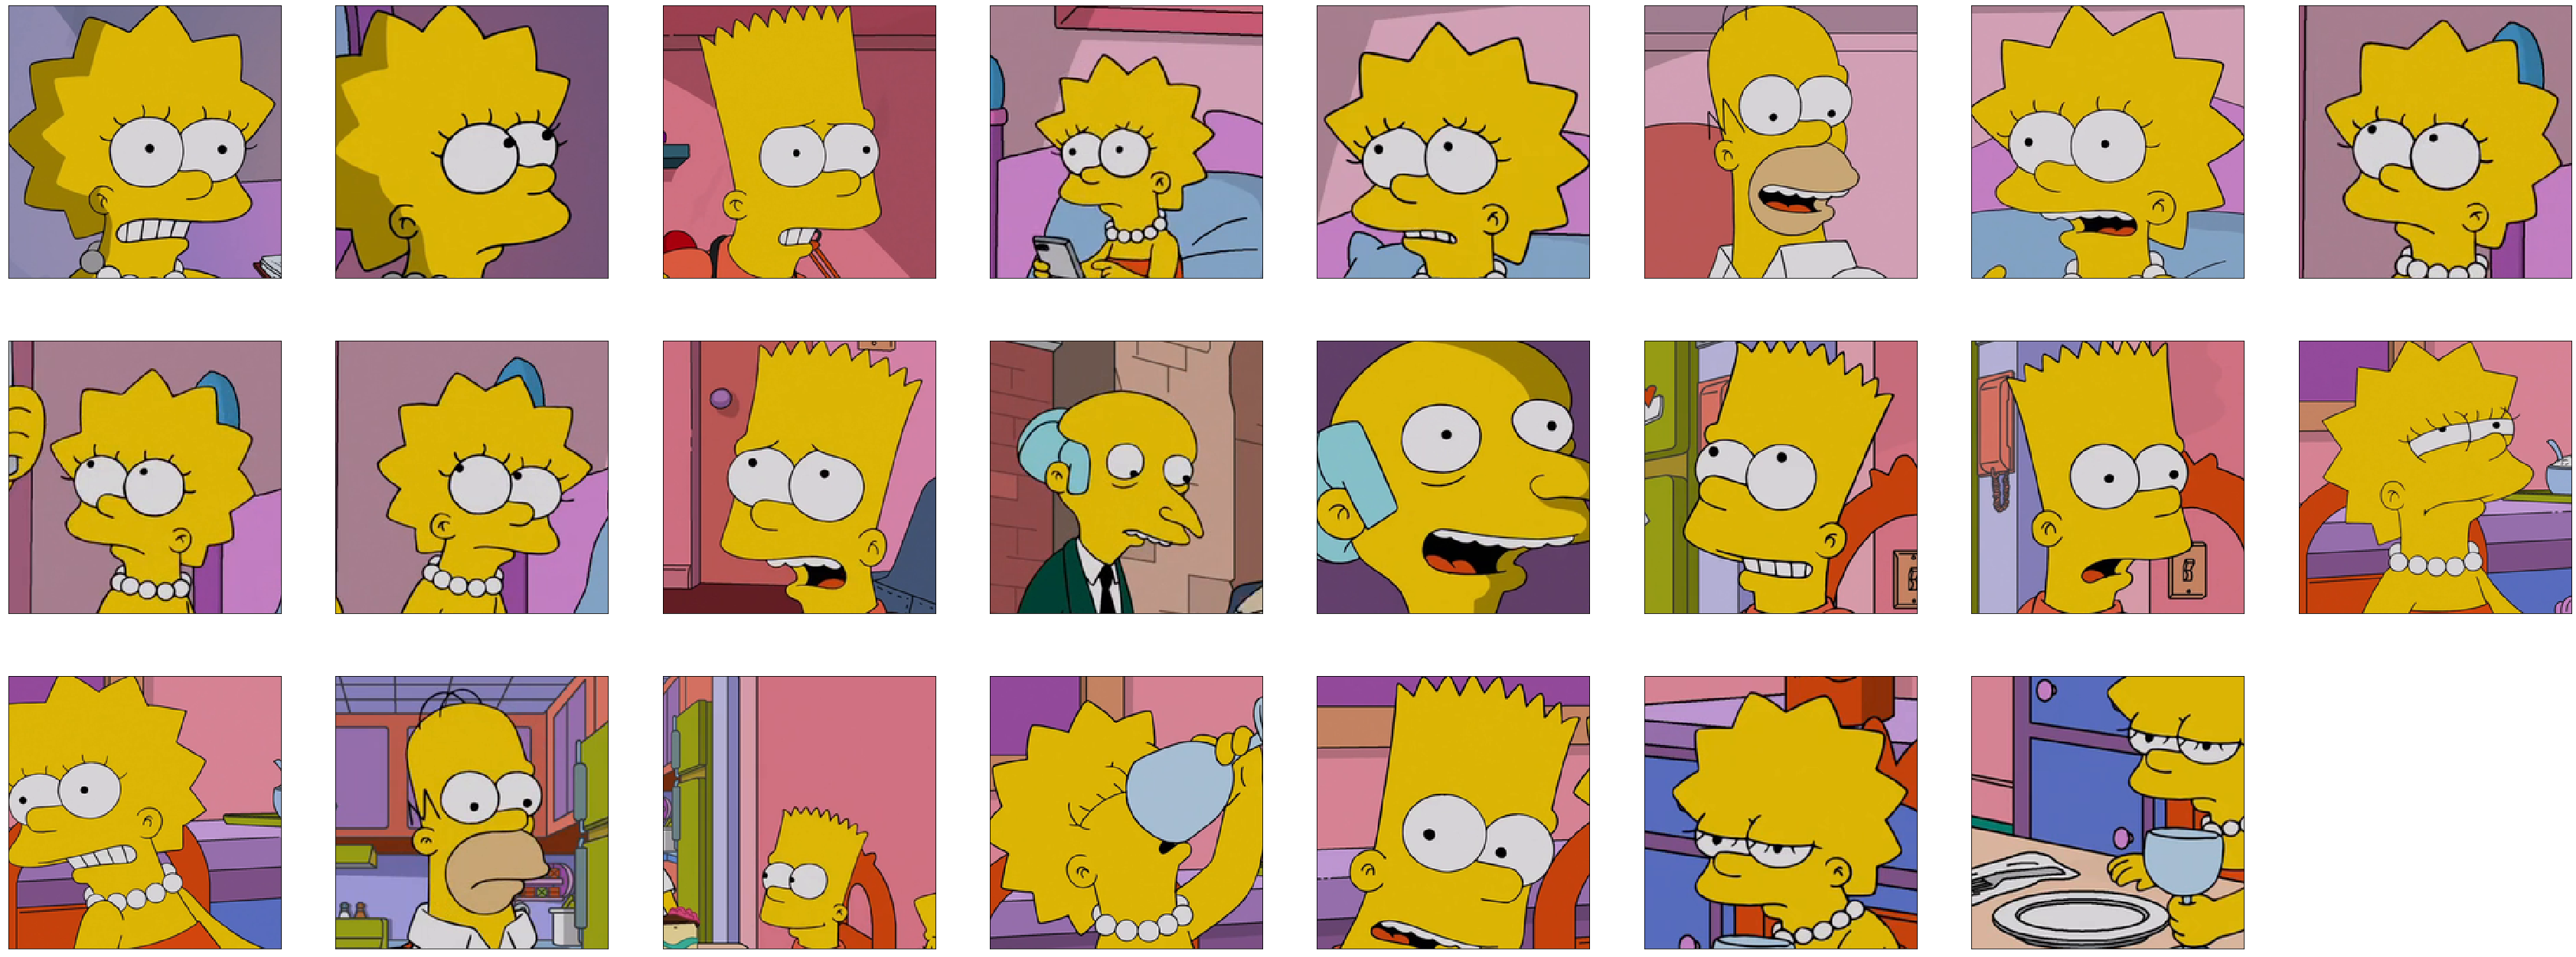

Cluster 2:


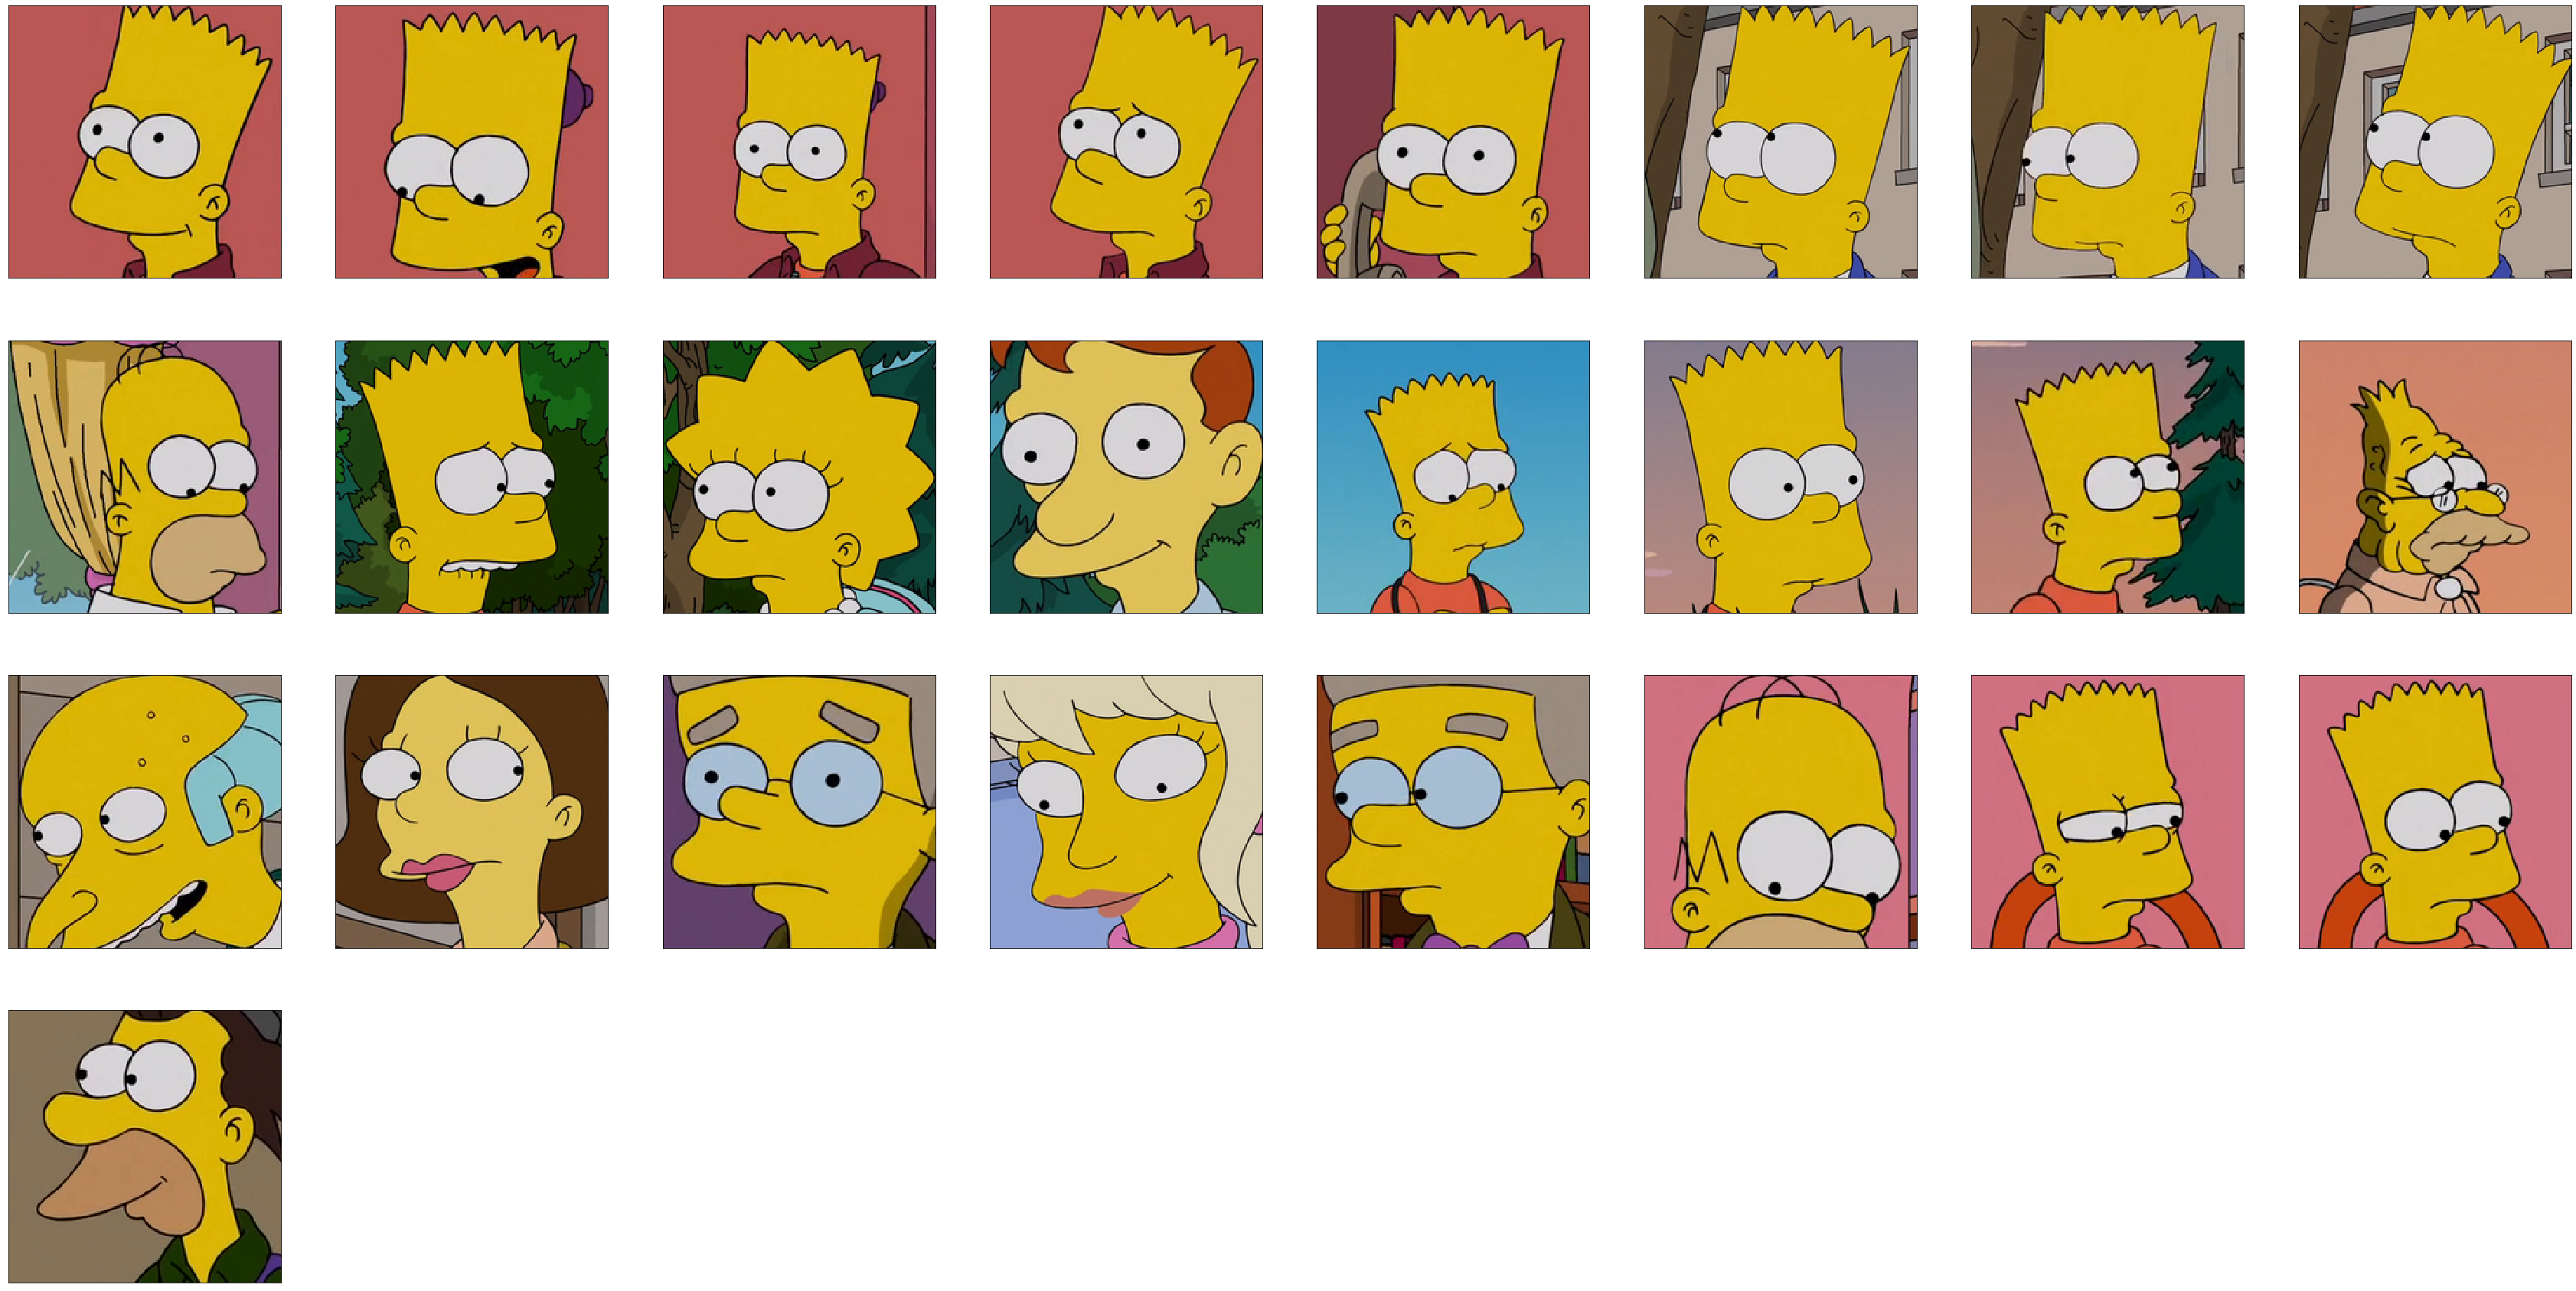

Cluster 3:


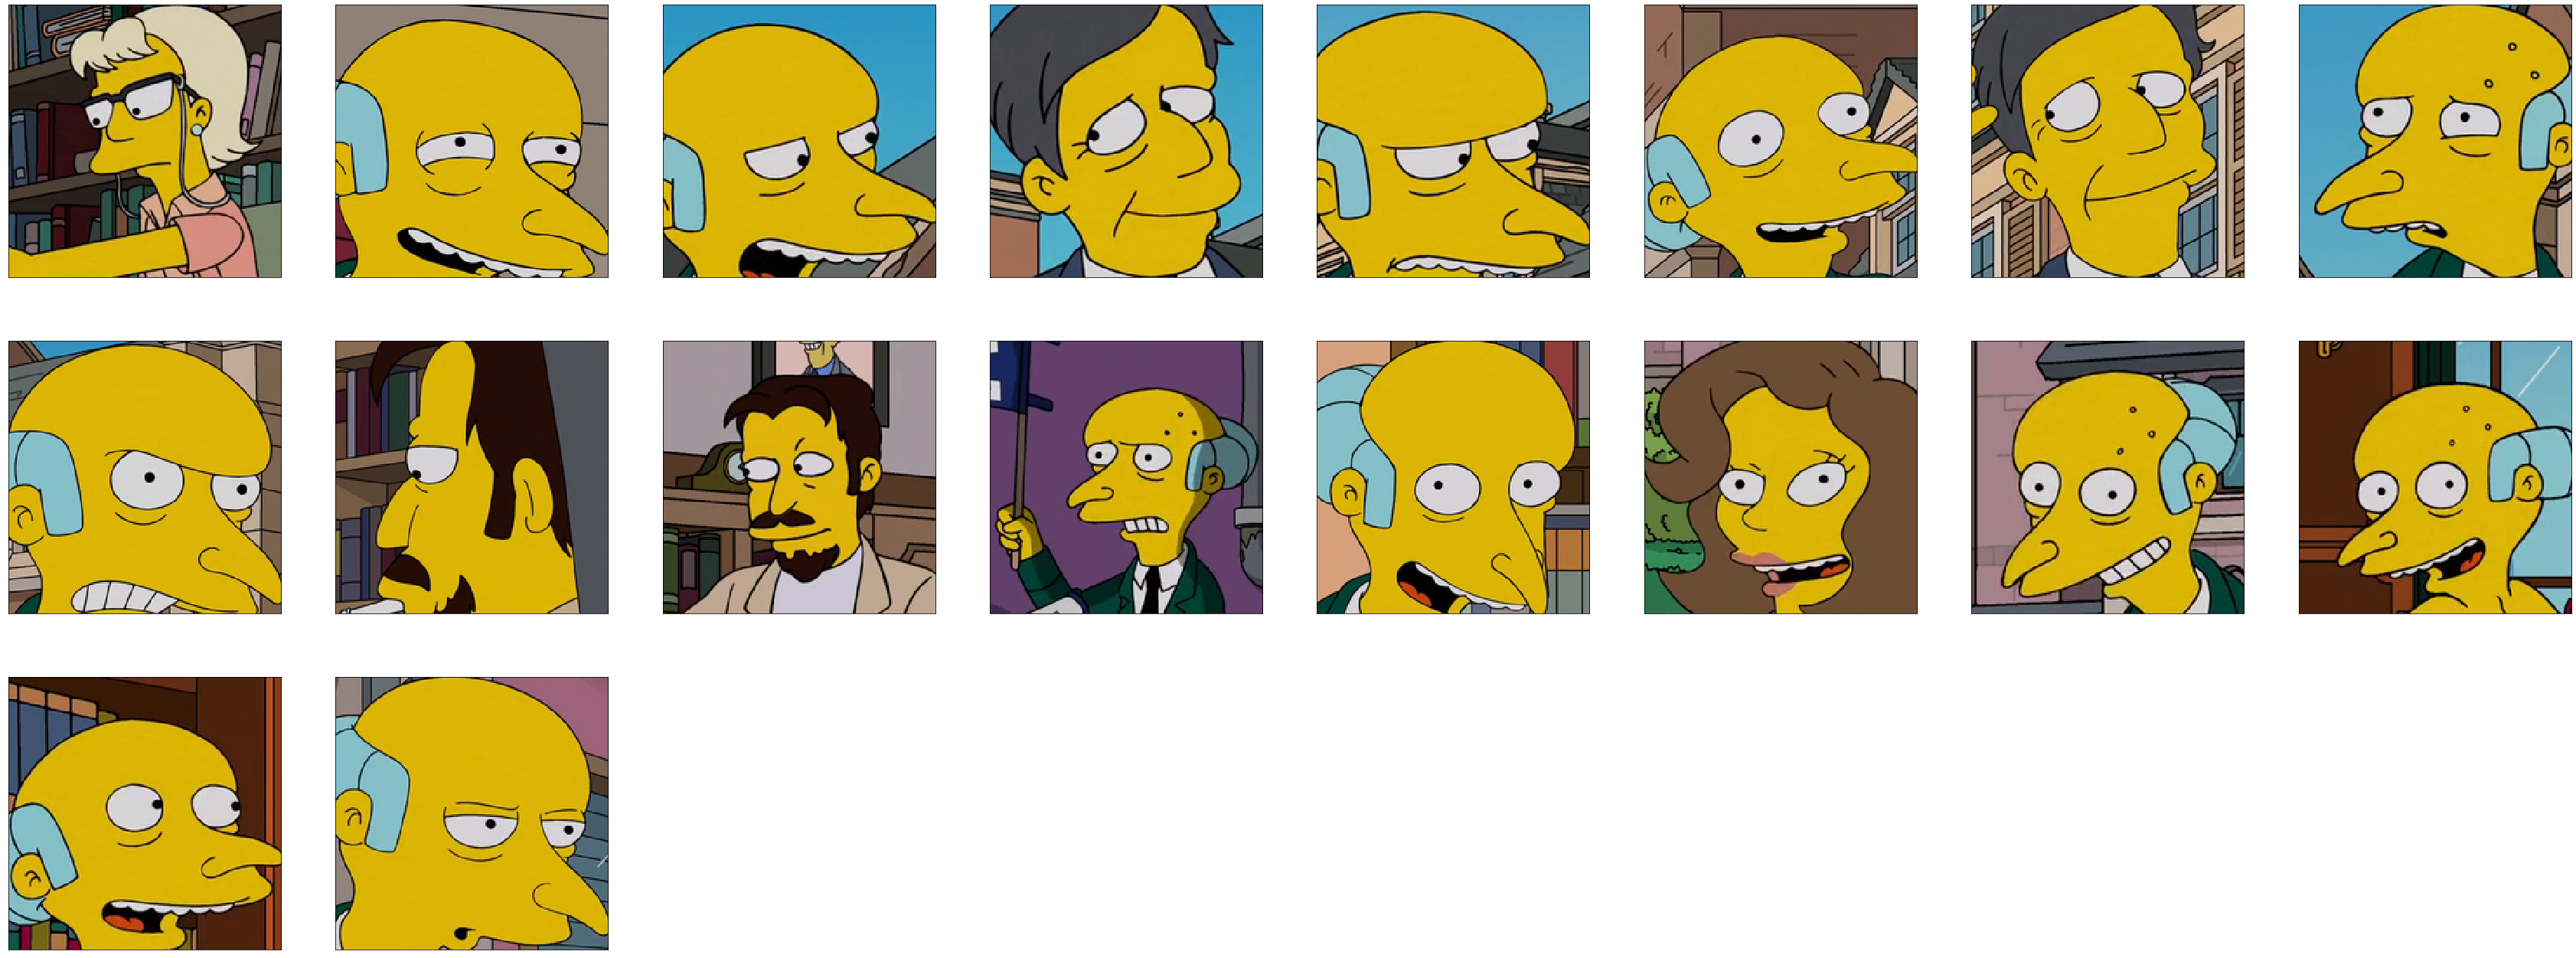

In [17]:
# displaying clusters content
print_clusters(main_catalog, files_list, clusters_kmean)

Each cluster brings together similar characters, their similar positions, as well as the colors observed both on the character itself and in the background.

In [18]:
# And/or sort them into categories

for c in range(len(clusters_kmean)):
    # Creating a folder for the current cluster
    os.mkdir(f'data/cluster{c}')
    for i in range(len(clusters_kmean[c])):
        # Move each cluster member to the created folder
        shutil.move(f'{main_catalog}/{files_list[clusters_kmean[c][i]]}',
                    f'data/cluster{c}/{files_list[clusters_kmean[c][i]]}')
# Deleting the starting folder
os.rmdir(main_catalog)

# What's next?

- Write function for cluster video files (LSTM + ResNet?) or for other data for which it is possible to receive embeddings
- Try another model (or ensemble of models) for feature extraction or try inrease performance of current model (knowledge distilation, fine-tuning by marked data, etc.) 
- Try another clustering method (you can see the ready variant on __[this](https://scikit-learn.org/stable/modules/clustering.html)__ page) - data embeddings can be arranged in such a way that naive k-means (the heuristic used in this notebook) is poorly suited for separating them